[comment]: <> "LTeX: language=fr"
# <center>Dissection d'un transformer : vision de bas niveau</center>
## <center>Jean-Philippe Magué, IXXI</center>
### <center>21 juin 2024</center>


Ce second notebook fait suite au précédent et plonge dans les détails de "bas niveau" de l'architecture du modèle [GPT2](https://huggingface.co/docs/transformers/en/model_doc/gpt2).
# Initialisation

In [1]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
torch.set_grad_enabled(False) #no training today!

In [3]:
model_name = 'openai-community/gpt2'

In [4]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_name)
gpt2 = GPT2LMHeadModel.from_pretrained(model_name,device_map="auto",pad_token_id=tokenizer.eos_token_id)
device = gpt2.device

In [5]:
print(f'GPT2 est un modèle avec {gpt2.config.n_layer} couches et un context de {gpt2.config.n_positions} positions.')

GPT2 est un modèle avec 12 couches et un context de 1024 positions.


# Embeddings
## Token embeddings

In [18]:
print(f'La dimension du modèle est de {gpt2.config.n_embd} dimensions.')

La dimension du modèle est de 768 dimensions.


In [28]:
prompt = " duck goose tiger lion bear train truck plane car boat ship"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| duck|  -> 22045
| goose| -> 37246
| tiger| -> 26241
| lion|  -> 18744
| bear|  -> 6842
| train| -> 4512
| truck| -> 7779
| plane| -> 6614
| car|   -> 1097
| boat|  -> 8848
| ship|  -> 4074


In [29]:
all_embeddings = gpt2.transformer.wte.weight.cpu().numpy()

In [30]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(11, 768)

In [31]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

(-2.5, 2.5)

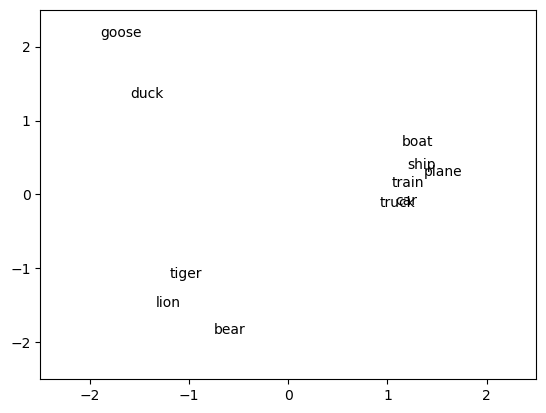

In [37]:
tokens = prompt.split(' ')[1:]
for i in range(len(tokens)):
    plt.text(coordinates[i,0],coordinates[i,1],tokens[i])
plt.xlim((-2.5,2.5))    
plt.ylim((-2.5,2.5))

In [39]:
prompt = " France Paris Germany Berlin Italy Rome Spain Madrid Belgium Brussels"
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| France| -> 4881
| Paris| -> 6342
| Germany| -> 4486
| Berlin| -> 11307
| Italy| -> 8031
| Rome|  -> 10598
| Spain| -> 8602
| Madrid| -> 14708
| Belgium| -> 15664
| Brussels| -> 16445


In [40]:
embeddings=all_embeddings[input['input_ids'][0].cpu().numpy()]
embeddings.shape

(10, 768)

In [41]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(embeddings)

(-2.0, 2.0)

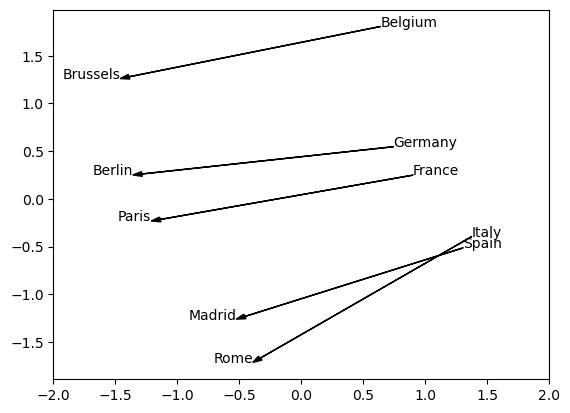

In [47]:
places = prompt.split(' ')[1:]
countries = [2*i for i in range(len(places)//2)]
cities = [2*i+1 for i in range(len(places)//2)]
for i in range(len(countries)):
    plt.arrow(coordinates[countries[i],0],coordinates[countries[i],1],coordinates[cities[i],0]-coordinates[countries[i],0],coordinates[cities[i],1]-coordinates[countries[i],1],color='black',head_width=0.05,length_includes_head=True)

for i,country in enumerate(countries):
    plt.text(coordinates[country,0],coordinates[country,1],places[country])
for i,city in enumerate(cities):
    plt.text(coordinates[city,0],coordinates[city,1],places[city], horizontalalignment='right')
plt.xlim((-2,2))

## Positional encoding

In [126]:
n=50
prompt = " test" * n # prompt = " test test test ....."
input = tokenizer(prompt, return_tensors="pt").to(device)
print(f'{"|token|":8} -> id\n')
for token in input['input_ids'][0]:
    print(f'{"|"+tokenizer.decode(token)+"|":8} -> {token}')

|token|  -> id

| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332
| test|  -> 1332


In [127]:
output = gpt2.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_new_tokens=1,
                       return_dict_in_generate=True, output_hidden_states=True)

In [128]:
len(output['hidden_states'][0])

13

In [129]:
pos_enc = output['hidden_states'][0][0][0].cpu().numpy()
pos_enc.shape

(50, 768)

In [130]:
pca = PCA(n_components=2)
coordinates = pca.fit_transform(pos_enc)
coordinates.shape

(50, 2)

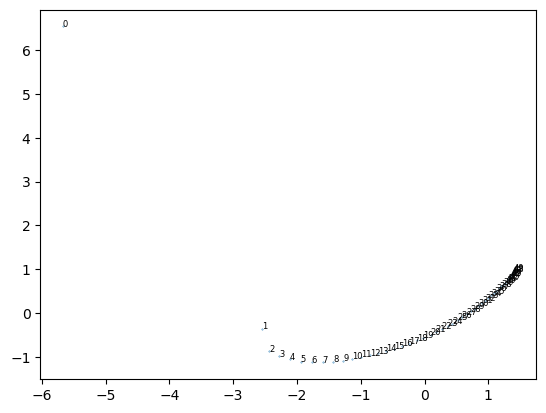

In [131]:
plt.scatter(coordinates[:,0],coordinates[:,1],s=.1)
for i in range(len(coordinates)):
    plt.text(coordinates[i,0],coordinates[i,1],str(i),fontsize=6)

In [139]:
gpt2.transformer.h[0].mlp

GPT2MLP(
  (c_fc): Conv1D()
  (c_proj): Conv1D()
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [141]:
gpt2.transformer.h[0].mlp.c_fc.weight.cpu().numpy().shape

(768, 3072)

In [142]:
gpt2.transformer.h[0].mlp.c_proj.weight.cpu().numpy().shape

(3072, 768)